 # EMD

/content/BCOT
### Results on wiki
L(X)=-1X
49.4±0.1 & 48.6±0.2 & 30.6±0.2
time: 7.24±0.68
db-index: 5.7±0.1
number of clusters: 17.0



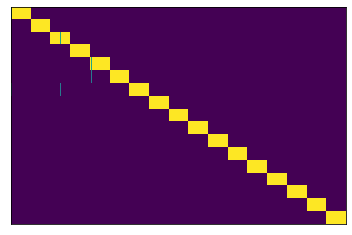

### Results on wiki
L(X)=-2405X
50.1±0.4 & 47.7±0.4 & 30.3±0.4
time: 7.38±1.98
db-index: 5.8±0.2
number of clusters: 17.0



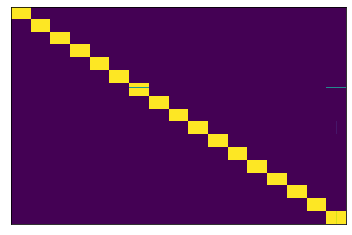

### Results on wiki
L(X)=-4973X
51.2±0.1 & 49.7±0.5 & 32.4±0.3
time: 5.97±1.86
db-index: 5.7±0.2
number of clusters: 17.0



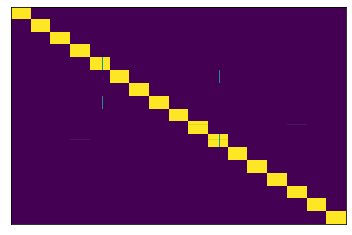

### Results on wiki
L(X)=-17X
50.8±0.9 & 48.7±1.3 & 31.3±0.9
time: 7.21±1.93
db-index: 5.8±0.1
number of clusters: 17.0



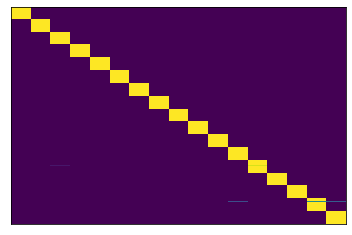

### Results on pubmed
L(X)=-1X
50.7±0.4 & 15.7±1.1 & 12.4±0.7
time: 8.27±2.39
db-index: 8.0±0.1
number of clusters: 3.0



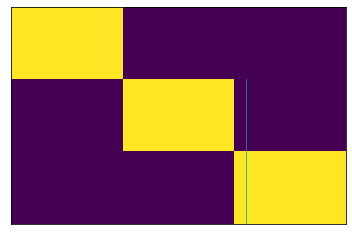

### Results on pubmed
L(X)=-19717X
57.1±1.2 & 17.2±0.4 & 14.9±1.0
time: 8.32±1.17
db-index: 7.3±0.6
number of clusters: 3.0



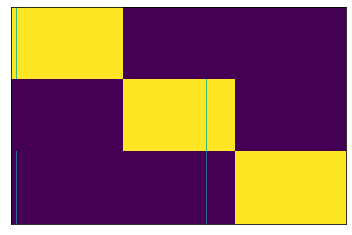

### Results on pubmed
L(X)=-500X
47.7±0.8 & 13.8±0.6 & 10.2±0.6
time: 5.16±1.01
db-index: 7.1±0.0
number of clusters: 3.0



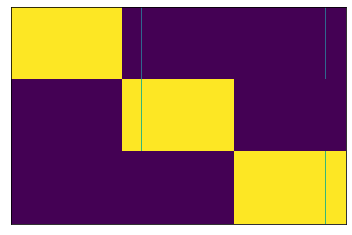

### Results on pubmed
L(X)=-3X
51.8±6.6 & 14.1±3.6 & 11.1±4.3
time: 10.02±0.83
db-index: 6.8±0.2
number of clusters: 3.0



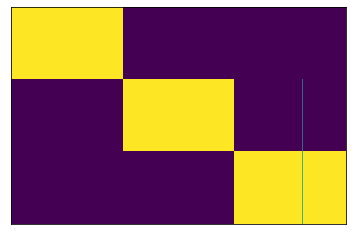

### Results on ng20
L(X)=-1X
31.2±1.4 & 27.9±0.9 & 16.4±0.9
time: 85.2±0.38
db-index: 10.5±0.1
number of clusters: 20.0



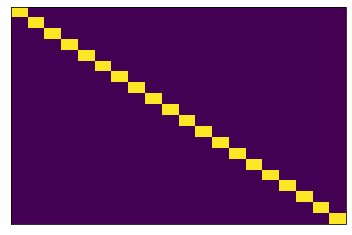

### Results on ng20
L(X)=-18846X
27.5±2.1 & 25.6±3.2 & 14.0±2.5
time: 124.47±12.46
db-index: 10.8±0.4
number of clusters: 20.0



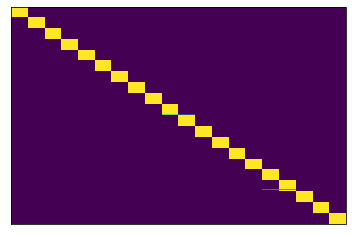

### Results on ng20
L(X)=-14390X
32.4±1.5 & 28.0±0.5 & 17.0±0.3
time: 108.89±4.01
db-index: 10.7±0.2
number of clusters: 20.0



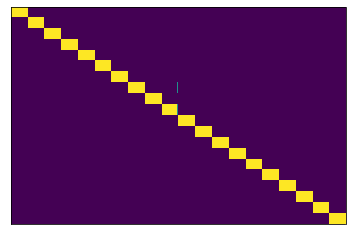

### Results on ng20
L(X)=-20X
34.4±1.1 & 29.9±0.0 & 19.1±0.2
time: 120.96±7.7
db-index: 10.9±0.5
number of clusters: 20.0



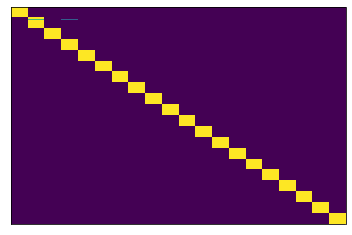

In [2]:
%cd /content/BCOT
%load_ext autoreload
%autoreload 2

import sys

import scipy.sparse as sp
from bcot.utils import read_dataset
from bcot.bcot import BCOT
from sklearn.metrics import normalized_mutual_info_score as nmi 
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import davies_bouldin_score
from bcot.metrics import clustering_accuracy
import numpy as np
from time import time 

n_runs = 2
plot_block_structure = True

for dataset in ['wiki', 'pubmed', 'ng20']:
  features, labels, n_classes = read_dataset(dataset, sparse=True)
  n, d = features.shape
  k = n_classes

  for scaler in [1, n, d, k]:    

    metrics = {}
    metrics['time'] = []
    metrics['acc'] = []
    metrics['nmi'] = []
    metrics['ari'] = []
    metrics['db'] = []
    metrics['avg_n_clust'] = []
    

    for _ in range(n_runs):
      t0 = time()
      M = -features * scaler
      
      Z_p, W_p = BCOT(M, n_classes, algorithm='emd', reg=1, n_iter=100)

      Z = Z_p.argmax(-1)
      W = W_p.argmax(-1)

      metrics['time'].append(time()-t0)
      metrics['acc'].append(clustering_accuracy(labels, Z)*100)
      metrics['nmi'].append(nmi(labels, Z)*100)
      metrics['ari'].append(ari(labels, Z)*100)
      try:
        metrics['db'].append(davies_bouldin_score(features.toarray(), Z))
      except:
        metrics['db'].append(np.nan)
      metrics['avg_n_clust'].append(len(np.unique(Z)))
      
      
    results = {
      'mean': {k:np.mean(v).round(1 if k != 'time' else 2) for k,v in metrics.items()}, 
      'std': {k:np.std(v).round(1 if k != 'time' else 2) for k,v in metrics.items()}
    }
    
    
    means = results['mean']
    std = results['std']
    print(f'### Results on {dataset}')
    print(f'L(X)=-{scaler}X')
    print(f"{means['acc']}±{std['acc']} & {means['nmi']}±{std['nmi']} & {means['ari']}±{std['ari']}", sep=',') 
    print(f"time: {means['time']}±{std['time']}")
    print(f"db-index: {means['db']}±{std['db']}")
    print(f"number of clusters: {means['avg_n_clust']}")
    print()

    if plot_block_structure:
      import matplotlib.pyplot as plt


      fig = plt.figure(figsize=(6, 4))
      ax = fig.add_subplot(111)

      # from bcot.utils import binarize
      # Z_p = binarize(Z_p.argmax(-1), k)
      # W_p = binarize(W_p.argmax(-1), k)

      ax.imshow((Z_p @ W_p.T)[Z.argsort()][:, W.argsort()], interpolation='nearest')
      ax.set_aspect('auto')

      plt.xticks([])
      plt.yticks([])
      plt.savefig(f'{dataset}-block-structure.pdf')
      plt.show()

# Sinkhorn 

/content/BCOT
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
### Results on wiki
L(X)=-1X, λ=0.0001
50.8±0.0 & 50.2±0.0 & 32.1±0.0
time: 26.55±0.0
db-index: 6.0±0.0
number of clusters: 17.0



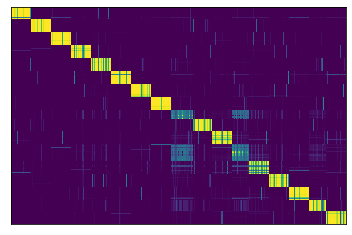

In [ ]:
%cd /content/BCOT
%load_ext autoreload
%autoreload 2

import sys
import warnings
warnings.filterwarnings("ignore")

import scipy.sparse as sp
from bcot.utils import read_dataset
from bcot.bcot import BCOT
from sklearn.metrics import normalized_mutual_info_score as nmi 
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import davies_bouldin_score
from bcot.metrics import clustering_accuracy
import numpy as np
from time import time 

n_runs = 1
plot_block_structure = True

for dataset in ['wiki']:
  features, labels, n_classes = read_dataset(dataset, sparse=True)
  n, d = features.shape
  k = n_classes

  for reg in [.0001, .001, .01, .1, 1, 1]:
    for scaler in [1, n, d, k]:

      metrics = {}
      metrics['time'] = []
      metrics['acc'] = []
      metrics['nmi'] = []
      metrics['ari'] = []
      metrics['db'] = []
      metrics['avg_n_clust'] = []
      

      for _ in range(n_runs):
        t0 = time()
        M = -features * scaler
        
        Z_p, W_p = BCOT(M, n_classes, algorithm='sinkhorn', reg=reg, n_iter=100)

        Z = Z_p.argmax(-1)
        W = W_p.argmax(-1)

        metrics['time'].append(time()-t0)
        metrics['acc'].append(clustering_accuracy(labels, Z)*100)
        metrics['nmi'].append(nmi(labels, Z)*100)
        metrics['ari'].append(ari(labels, Z)*100)
        try:
          metrics['db'].append(davies_bouldin_score(features.toarray(), Z))
        except:
          metrics['db'].append(np.nan)
        metrics['avg_n_clust'].append(len(np.unique(Z)))
        
        
      results = {
        'mean': {k:np.mean(v).round(1 if k != 'time' else 2) for k,v in metrics.items()}, 
        'std': {k:np.std(v).round(1 if k != 'time' else 2) for k,v in metrics.items()}
      }
      
      
      means = results['mean']
      std = results['std']
      print(f'### Results on {dataset}')
      print(f'L(X)=-{scaler}X, λ={reg}')
      print(f"{means['acc']}±{std['acc']} & {means['nmi']}±{std['nmi']} & {means['ari']}±{std['ari']}", sep=',') 
      print(f"time: {means['time']}±{std['time']}")
      print(f"db-index: {means['db']}±{std['db']}")
      print(f"number of clusters: {means['avg_n_clust']}")
      print()

      if plot_block_structure:
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(111)

        # from bcot.utils import binarize
        # Z_p = binarize(Z_p.argmax(-1), k)
        # W_p = binarize(W_p.argmax(-1), k)

        ax.imshow((Z_p @ W_p.T)[Z.argsort()][:, W.argsort()], interpolation='nearest')
        ax.set_aspect('auto')

        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'{dataset}-block-structure.pdf')
        plt.show()
        